<div style="page-break-after: always;"></div>

![](https://github.com/zumaiaUOC/DL_PRA/blob/main/media/001.png?raw=1)![](https://github.com/zumaiaUOC/DL_PRA/blob/main/media/002.jpeg?raw=1)

**M2.875 Deep Learning**

Práctica                    Autor: Oscar Rojo Martín

# *Clasificador Neuronal para la detección de Glaucoma*

<div style="page-break-after: always;"></div>

1.  Presentación

El objetivo de esta práctica es aplicar los conocimientos adquiridos durante toda la asignatura en un caso clínico real. Para ello se dispondrá de una base de datos que contiene imágenes de ojos sanos y de otros afectados por glaucoma. El glaucoma es una patología que afecta al nervio óptico y cuyos orígenes son diversos, es la segunda causa de ceguera por detrás de la diabetes y los efectos en la pérdida de visión son irreversibles. Las causas que lo producen se pueden tratar si la patología es detectada a tiempo.

El objetivo final de esta práctica es, mediante los conocimientos adquiridos, proponer y entrenar un algoritmo que sea capaz de detectar adecuadamente ojos con glaucoma frente a otros sanos.


  
1. Definición del problema

Los algoritmos de reconocimiento de imágenes se están implementando en la práctica clínica, integrándose en ocasiones directamente en el hardware que se utiliza para la exploración (por ejemplo, en los ecógrafos). Este tipo de aproximación es lo que se propone en el siguiente artículo científico, el cual se utilizará como base para realizar esta práctica:

- Diaz-Pinto, A., Morales, S., Naranjo, V. et al. *CNNs for automatic glaucoma assessment using fundus images: an extensive validation*. BioMed Eng OnLine 18, 29 (2019). <https://doi.org/10.1186/s12938-019-0649-y>

En esta práctica se dispone de una serie de imágenes de casos reales. El objetivo es obtener un modelo eficaz para detectar de manera temprana esta patología, reduciendo, por lo tanto, el riesgo de ceguera.

La base de datos está formada por imágenes en color de 224x224 píxeles y se ha dividido en 10 particiones distintas que se usarán para aplicar un método de *cross validation* con el objetivo de minimizar errores estadísticos. Cada una de estas particiones, a su vez, contiene tres subconjuntos: *train*, *test* y *valid*. Las imágenes a su vez están etiquetadas de dos formas: *normal* o *abnormal*.


2. Función de evaluación

La función de evaluación que se utilizará a lo largo de la práctica será el **F1-score**.

6. Recursos

El conjunto de los datos del proyecto se puede encontrar en la dirección:

- <https://www.kaggle.com/datasets/jordidelatorreuoc/practica-dl-uoc-2022>



In [1]:
# Clono el repositorio de GitHub donde tengo guardado todos los archivos
# Esto último lo hago para ejecutar en google colab y no tener que hacerlo en
# un notebook... que no permite grandes cantidades procesos.
! git clone https://github.com/zumaiaUOC/DL_PRA.git
% cd /content/DL_PRA

Cloning into 'DL_PRA'...
remote: Enumerating objects: 1947, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 1947 (delta 50), reused 124 (delta 48), pack-reused 1821
Receiving objects: 100% (1947/1947), 43.60 MiB | 33.82 MiB/s, done.
Resolving deltas: 100% (94/94), done.
Checking out files: 100% (17115/17115), done.
/content/DL_PRA


#### Importar librerias

In [2]:
# ultima version de tensorflow
#!pip install tf-nightly
# addons para utilizar F1 score
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.5 MB/s 


In [3]:
# Import libraries
from keras.callbacks import ModelCheckpoint, EarlyStopping
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from numpy import asarray
import tensorflow as tf
import sklearn
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from sklearn.preprocessing import OneHotEncoder
import tensorflow_addons as tfa

import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelBinarizer

tf.random.set_seed(42) # para reproducibilidad



In [4]:
# mount the drive
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# go to the folder with the images
#% cd /content/drive/MyDrive/Colab Notebooks/DL-PRA

#### Cargar los datos desde kaggle usando API

In [6]:
# Import data from kaggle using Kaggle API
# ref.:https://medium.com/@jeff.daniel77/accessing-the-kaggle-com-api-with-jupyter-notebook-on-windows-d6f330bc6953
# ! kaggle datasets download -d jordidelatorreuoc/practica-dl-uoc-2022


In [7]:
# unzip to data folder
# ! unzip -o practica-dl-uoc-2022.zip -d data/

In [8]:
# drop practica-dl-uoc-2022.zip
# ! rm practica-dl-uoc-2022.zip

In [9]:
# Load data
base_dir = 'data/practica_DL_UOC_2022/'

# list folder in data/practica-dl-uoc-2022/
subfolder = os.listdir(base_dir)
print(subfolder)


['Fold1', 'Fold4', 'Fold0', 'Fold3', 'Fold8', 'Fold2', 'Fold5', 'Fold7', 'Fold9', 'Fold6']


In [10]:
train_dir = os.path.join(base_dir, subfolder[0]+'/train/')
test_dir = os.path.join(base_dir, subfolder[0]+'/test/')
valid_dir = os.path.join(base_dir, subfolder[0]+'/valid/')

# directorio con imagenes normal de entrenamiento
train_normal_dir = os.path.join(train_dir, 'normal/')
# directorio con imagenes abnormal de entrenamiento
train_anormal_dir = os.path.join(train_dir, 'abnormal/')

# directorio con imagenes normal de test
test_normal_dir = os.path.join(test_dir, 'normal/')
# directorio con imagenes abnormal de test
test_anormal_dir = os.path.join(test_dir, 'abnormal/')

# directorio con imagenes normal de validacion
valid_normal_dir = os.path.join(valid_dir, 'normal/')
# directorio con imagenes abnormal de validacion
valid_anormal_dir = os.path.join(valid_dir, 'abnormal/')


In [11]:
train_anormal_dir_list = os.listdir(train_anormal_dir)
print(train_anormal_dir_list[0])

oSxoEaSoHR.jpg


#### Crear dataframe

In [12]:
df_all = pd.DataFrame()
norm_abnorm = ['normal', 'abnormal']
train_test_valid = ['train', 'test', 'valid']
for i in subfolder:
    for h in train_test_valid:
        for j in norm_abnorm:
            x_dir = os.path.join(base_dir, i+'/'+h+'/'+j+'/')
            x_dir_list = os.listdir(x_dir)
            # create a dataframe with fold, set, status, image and full_path
            df = pd.DataFrame(x_dir_list, columns=['image'])
            df['fold'] = i
            df['set'] = h
            df['status'] = j
            df['full_path'] = df['image'].apply(lambda x: os.path.join(x_dir, x))
            df_all = pd.concat([df_all, df])

df_all 

,image,fold,set,status,full_path
0,WeyEZHlbVV.jpg,Fold1,train,normal,data/practica_DL_UOC_2022/Fold1/train/normal/W...
1,GEdLbllOrL.jpg,Fold1,train,normal,data/practica_DL_UOC_2022/Fold1/train/normal/G...
2,hxolFIPeVb.jpg,Fold1,train,normal,data/practica_DL_UOC_2022/Fold1/train/normal/h...
3,embyZorZmz.jpg,Fold1,train,normal,data/practica_DL_UOC_2022/Fold1/train/normal/e...
4,bDPsGesQtp.jpg,Fold1,train,normal,data/practica_DL_UOC_2022/Fold1/train/normal/b...
...,...,...,...,...,...
65,ErXihucXJQ.jpg,Fold6,valid,abnormal,data/practica_DL_UOC_2022/Fold6/valid/abnormal...
66,dPNTYocBLU.jpg,Fold6,valid,abnormal,data/practica_DL_UOC_2022/Fold6/valid/abnormal...
67,gwnLFsoNDm.jpg,Fold6,valid,abnormal,data/practica_DL_UOC_2022/Fold6/valid/abnormal...
68,SUGFWkeBAl.jpg,Fold6,valid,abnormal,data/practica_DL_UOC_2022/Fold6/valid/abnormal...


In [13]:
# Comprobar que el numero de imagenes es correcto



# **Sección 1. Análisis Exploratorio de los datos (1,5 puntos)**

Realizar un análisis exploratorio de los datos proporcionados, tanto en formato numérico como gráfico, donde se recoja la información relevante del conjunto de datos proporcionado.


In [14]:
df_all_train = pd.DataFrame()
norm_abnorm = ['normal', 'abnormal']
for i in subfolder:
    for j in norm_abnorm:
        train_dir = os.path.join(base_dir, i+'/train/')
        train_dir_dir = os.path.join(train_dir, j+'/')
        train_dir_list = os.listdir(train_dir_dir)
        # create a dataframe with fold, set, status, image, and full path
        df_train = pd.DataFrame({'fold': [i]*len(train_dir_list),
                                    'set': [j]*len(train_dir_list),
                                    'status': [j]*len(train_dir_list),
                                    'image': train_dir_list,
                                    'full_path': [os.path.join(train_dir_dir, x) for x in train_dir_list]})
        df_all_train = pd.concat([df_all_train, df_train])

print ("Numero de imagenes en train: ", len(df_all_train))
print("Dimension de train: ", df_all_train.shape)
    

Numero de imagenes en train:  13790
Dimension de train:  (13790, 5)


In [15]:
df_all_test = pd.DataFrame()
norm_abnorm = ['normal', 'abnormal']
for i in subfolder:
    for j in norm_abnorm:
        test_dir = os.path.join(base_dir, i+'/test/')
        test_dir_dir = os.path.join(test_dir, j+'/')
        test_dir_list = os.listdir(test_dir_dir)
        # create a dataframe with fold, set, status, image, and full path
        df_test = pd.DataFrame({'fold': [i]*len(test_dir_list),
                                'set': [j]*len(test_dir_list),
                                'status': [j]*len(test_dir_list),
                                'image': test_dir_list,
                                'full_path': [os.path.join(test_dir_dir, x) for x in test_dir_list]})
        df_all_test = pd.concat([df_all_test, df_test])

print("Numero de imagenes en test: ", len(df_all_test))
print("Dimension de test: ", df_all_test.shape)



Numero de imagenes en test:  1740
Dimension de test:  (1740, 5)


In [16]:
df_all_valid = pd.DataFrame()
norm_abnorm = ['normal', 'abnormal']
for i in subfolder:
    for j in norm_abnorm:
        valid_dir = os.path.join(base_dir, i+'/valid/')
        valid_dir_dir = os.path.join(valid_dir, j+'/')
        valid_dir_list = os.listdir(valid_dir_dir)
        # create a dataframe with fold, set, status, image, and full path
        df_valid = pd.DataFrame({'fold': [i]*len(valid_dir_list),
                                 'set': [j]*len(valid_dir_list),
                                 'status': [j]*len(valid_dir_list),
                                 'image': valid_dir_list,
                                 'full_path': [os.path.join(valid_dir_dir, x) for x in valid_dir_list]})
        df_all_valid = pd.concat([df_all_valid, df_valid])

print("Numero de imagenes en valid: ", len(df_all_valid))
print("Dimension de valid: ", df_all_valid.shape)


Numero de imagenes en valid:  1540
Dimension de valid:  (1540, 5)


In [17]:
# Numero de imagles normal para train, test y valid
df_all_test_normal = df_all_test[df_all_test['status'] == 'normal']
print("Numero de imagenes normal en test: ", len(df_all_test_normal))
print("Numero de imagenes abnorma en test: ", len(df_all_test) - len(df_all_test_normal))
# para train
df_all_train_normal = df_all_train[df_all_train['status'] == 'normal']
print("Numero de imagenes normal en train: ", len(df_all_train_normal))
print("Numero de imagenes abnorma en train: ", len(df_all_train) - len(df_all_train_normal))
# para valid
df_all_valid_normal = df_all_valid[df_all_valid['status'] == 'normal']
print("Numero de imagenes normal en valid: ", len(df_all_valid_normal))
print("Numero de imagenes abnorma en valid: ", len(df_all_valid) - len(df_all_valid_normal))



Numero de imagenes normal en test:  919
Numero de imagenes abnorma en test:  821
Numero de imagenes normal en train:  7452
Numero de imagenes abnorma en train:  6338
Numero de imagenes normal en valid:  819
Numero de imagenes abnorma en valid:  721


Dimensión: (17070, 5)


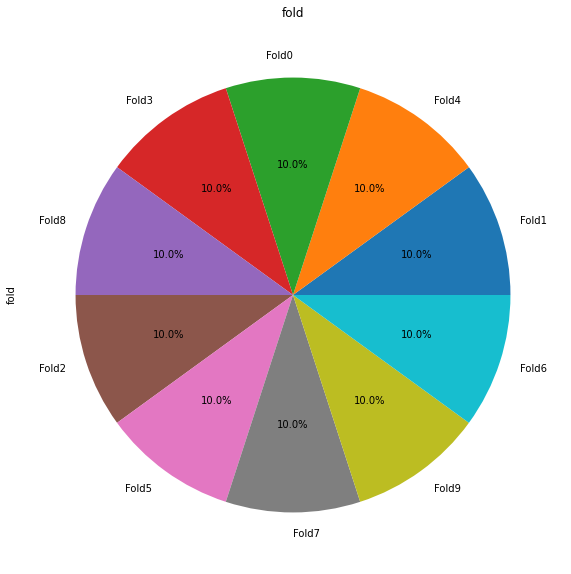

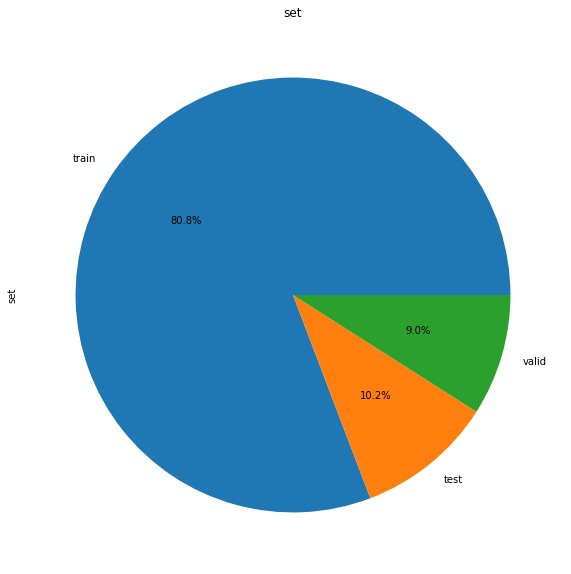

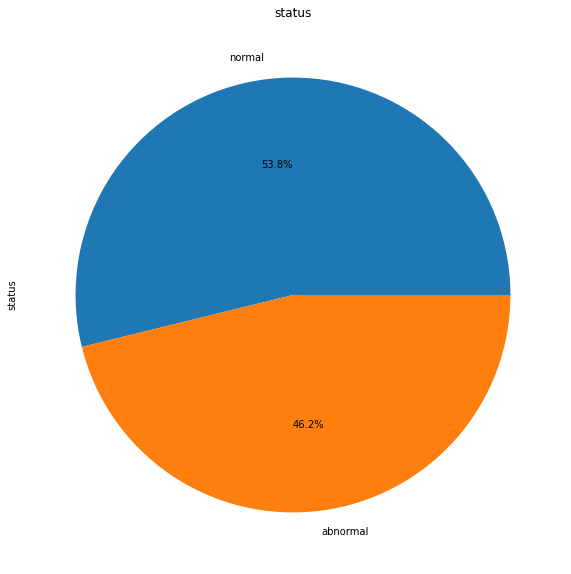

In [18]:
# Dimensión
print("Dimensión: {}".format(df_all.shape))

# list of columns
column_list = ['fold', 'set', 'status']   



# pie chart 
for i in column_list:
    df_all[i].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10, 10))
    plt.title(i)
    plt.show()




In [19]:
# load images
def load_image(path):
    image = Image.open(path)
    image = image.resize((224, 224))
    image = np.array(image)
    return image

load_image(df_all.iloc[0]['full_path'])


array([[[194,  86,  13],
        [195,  87,  14],
        [194,  88,  14],
        ...,
        [192,  90,  16],
        [191,  89,  15],
        [191,  89,  15]],

       [[194,  86,  13],
        [194,  88,  14],
        [195,  89,  15],
        ...,
        [188,  87,  15],
        [188,  87,  15],
        [188,  86,  14]],

       [[196,  88,  15],
        [196,  90,  16],
        [197,  91,  17],
        ...,
        [187,  86,  18],
        [187,  86,  18],
        [187,  86,  18]],

       ...,

       [[209,  93,  16],
        [210,  93,  16],
        [212,  92,  16],
        ...,
        [222, 106,  29],
        [222, 106,  29],
        [221, 105,  28]],

       [[209,  93,  16],
        [209,  92,  15],
        [212,  90,  15],
        ...,
        [222, 106,  29],
        [222, 106,  29],
        [222, 106,  29]],

       [[210,  94,  17],
        [210,  93,  16],
        [212,  90,  15],
        ...,
        [221, 105,  28],
        [222, 106,  29],
        [223, 107,  30]]

In [20]:
df_all_normal = df_all[df_all['status'] == 'normal']
df_all_abnormal = df_all[df_all['status'] == 'abnormal']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Imagen Normal
JPEG
RGB
(224, 224)
Mean: 114.685
Min: 7.000, Max: 255.000
Mean: 0.000
Min: -107.685, Max: 140.315
Data Type: float64
Min: -107.685, Max: 140.315
pixel mean =  -4.2828168e-09
Min: -0.422, Max: 0.550


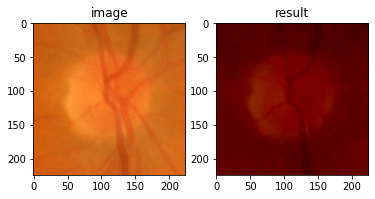

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Imagen Abnormal
JPEG
RGB
(224, 224)
Mean: 45.953
Min: 0.000, Max: 207.000
Mean: 0.000
Min: -45.953, Max: 161.047
Data Type: float64
Min: -45.953, Max: 161.047
pixel mean =  5.980738e-09
Min: -0.180, Max: 0.632


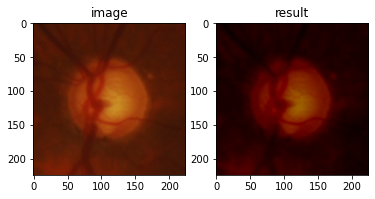

In [21]:
def image_info(path):
    image = Image.open(path)
    print(image.format)
    print(image.mode)
    print(image.size)
    pixels = asarray(image)
    # global centering


    # calculate global mean
    mean = pixels.mean()
    print('Mean: %.3f' % mean)
    print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
    # global centering of pixels
    pixels = pixels - mean
    # confirm it had the desired effect
    mean = pixels.mean()
    print('Mean: %.3f' % mean)
    print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
    #print(pixels)


    # example of pixel normalization
    # confirm pixel range is 0-255
    print('Data Type: %s' % pixels.dtype)
    print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
    # convert from integers to floats
    pixels = pixels.astype('float32')
    # normalize to the range 0-1
    pixels /= 255.0
    mean = pixels.mean()
    print('pixel mean = ', mean)

    # confirm the normalization
    print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

    # show the image
    fig, (ax0, ax1) = plt.subplots(1, 2)
    ax0.imshow(image)
    ax0.axis('on')
    ax0.set_title('image')
    ax1.imshow(pixels)
    ax1.axis('on')
    ax1.set_title('result')
    plt.show()
    
print('Imagen Normal')
image_info(df_all_normal.iloc[0]['full_path'])
print('Imagen Abnormal')
image_info(df_all_abnormal.iloc[0]['full_path'])


In [22]:
def imagen(path):
    image = Image.open(path)
    pixels = asarray(image) # convert image to numpy array
    # calculate global mean
    mean = pixels.mean()
    # global centering of pixels
    pixels = pixels - mean
    # convert from integers to floats
    pixels = pixels.astype('float32')
    # normalize to the range 0-1
    pixels /= 255.0
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 14))
    ax0.imshow(image)
    ax0.axis('on')
    ax0.set_title('original image', fontsize=20)
    ax1.imshow(pixels)
    ax1.axis('on')
    ax1.set_title('result', fontsize=20)
    plt.show()

# imagen(df_all.iloc[0]['full_path'])

##### ojo sano:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


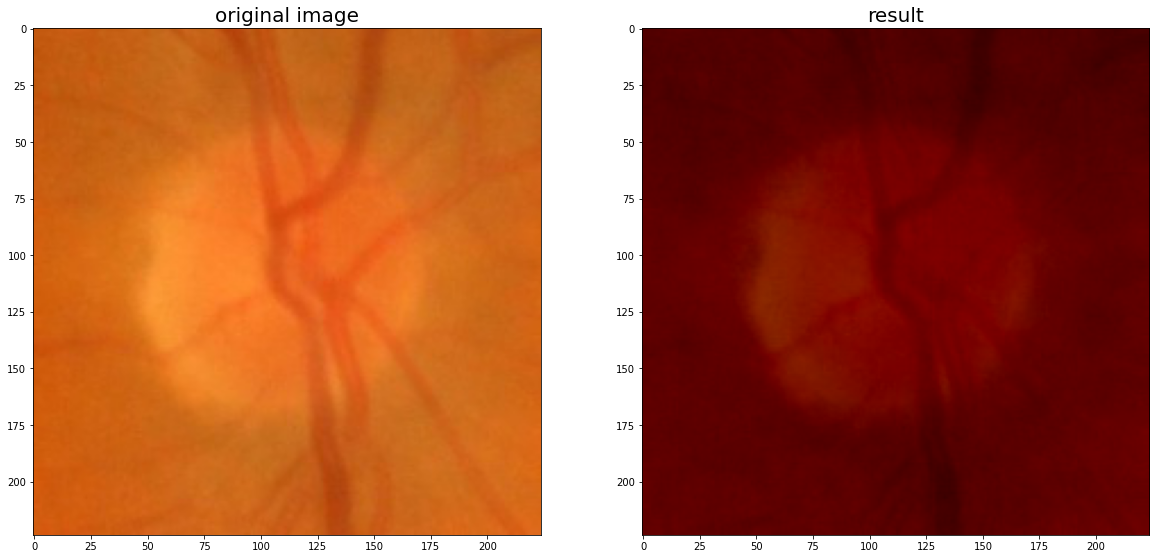

In [23]:
# filter df_all status = normal
df_all_normal = df_all[df_all['status'] == 'normal']
imagen(df_all_normal.iloc[0]['full_path'])

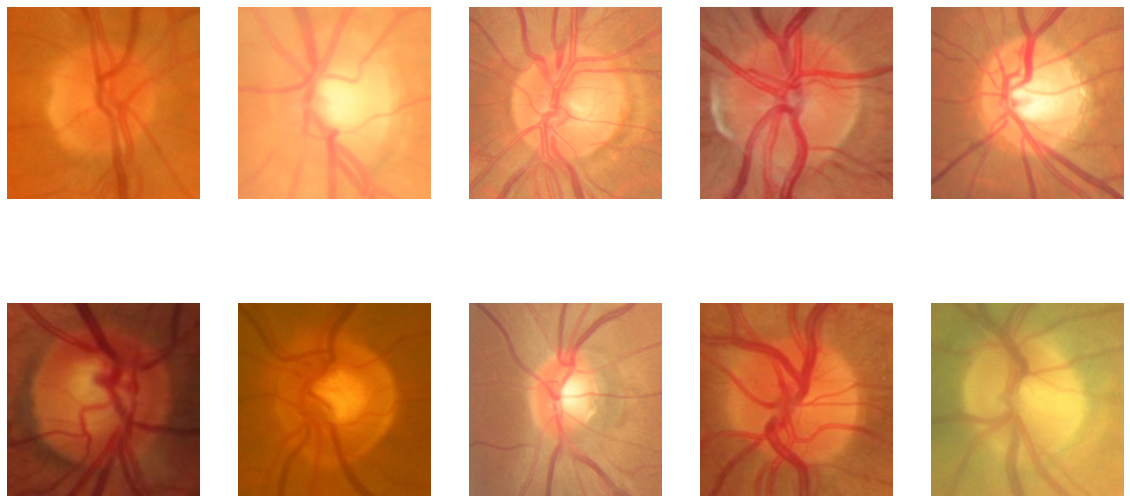

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
for i in range(10):
    axes[i//5, i%5].imshow(load_image(df_all_normal.iloc[i]['full_path']))
    axes[i//5, i%5].axis('off')
plt.show()

##### ojo con Glaucoma:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


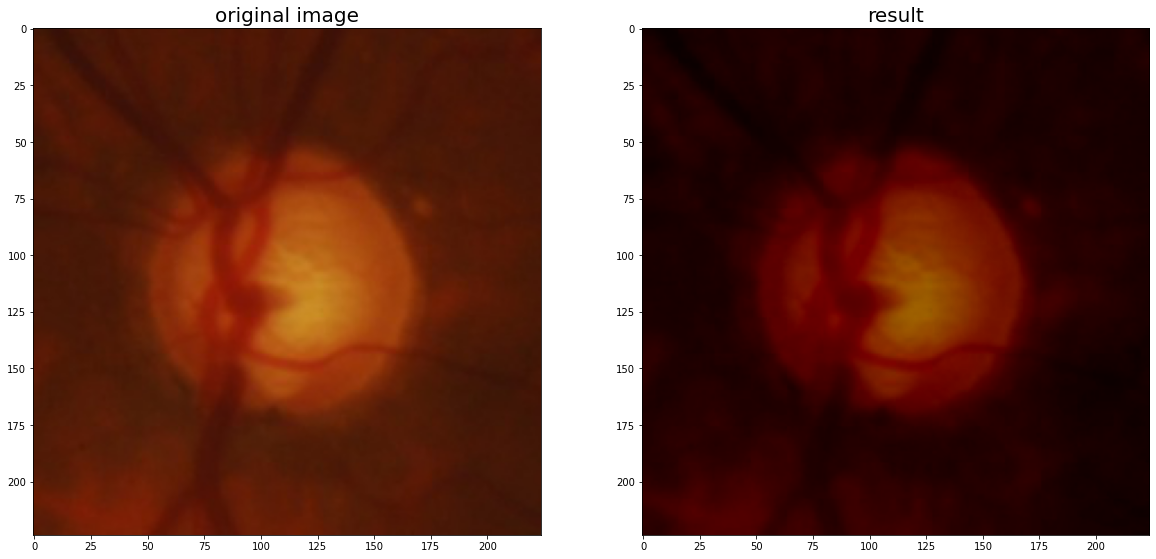

In [25]:
# filter df_all status = abnormal
df_all_abnormal = df_all[df_all['status'] == 'abnormal']
imagen(df_all_abnormal.iloc[0]['full_path'])

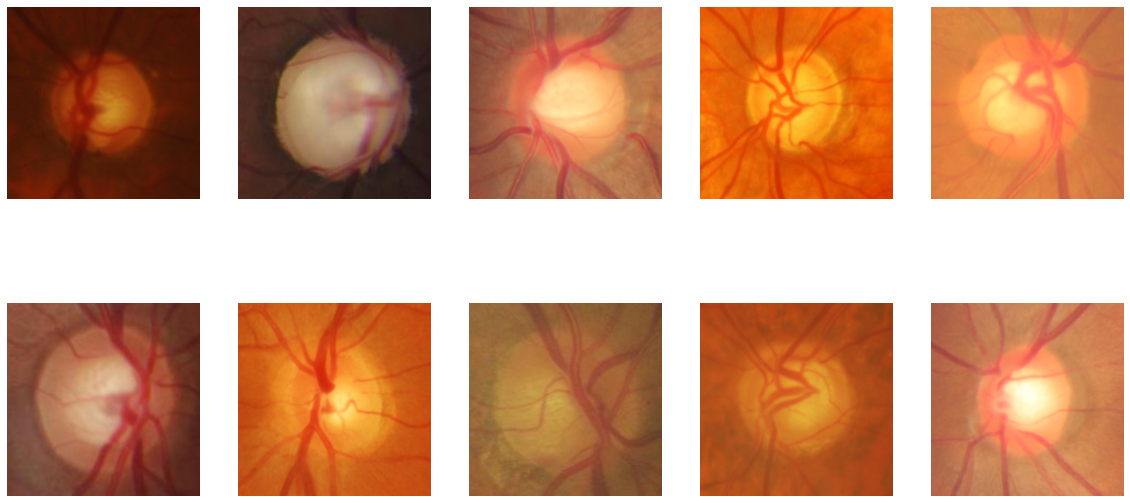

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
for i in range(10):
    axes[i//5, i%5].imshow(load_image(df_all_abnormal.iloc[i]['full_path']))
    axes[i//5, i%5].axis('off')
plt.show()


# **Sección 2. Entrenamiento de una red neuronal sobre una única partición (4 puntos)**

En esta primera parte se hará un entrenamiento únicamente sobre el **fold0**. Esto nos permitirá obtener conclusiones preliminares en un plazo razonable de tiempo, antes de ejecutar un entrenamiento completo empleando *cross validation* (ver sección 3). Para ello se deben proponer y comparar 5 aproximaciones distintas:

- Las 3 primeras configuraciones se deben implementar en un modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*.
  - En la primera configuración se entrena el modelo congelando todas las capas menos las que se han añadido al final (**modelo 1**).
  - En una segunda configuración, a partir de los pesos encontrados para el modelo 1, se entrena descongelando las últimas 20 capas, pero dejando las capas de *BatchNorm* congeladas (**modelo 2**).
  - En la tercera configuración, a partir de los pesos del modelo 2, se descongelan todas las capas y se entrena la red en su totalidad (**modelo 3**).
- Entrenar dos configuraciones, modelos o arquitecturas adicionales, que se pueden escoger libremente (**modelo 4** y **modelo 5**).

En todos los casos, se debe indicar y justificar:

- Elegir la época e hiperparámetros que mejor resultados hayan proporcionado sobre el conjunto de validación durante el entrenamiento.
- Proporcionar y discutir los resultados sobre el conjunto de test.
- Obtener la matriz de confusión, y discutir los resultados teniendo en cuenta los objetivos del problema.


In [27]:
df_all

,image,fold,set,status,full_path
0,WeyEZHlbVV.jpg,Fold1,train,normal,data/practica_DL_UOC_2022/Fold1/train/normal/W...
1,GEdLbllOrL.jpg,Fold1,train,normal,data/practica_DL_UOC_2022/Fold1/train/normal/G...
2,hxolFIPeVb.jpg,Fold1,train,normal,data/practica_DL_UOC_2022/Fold1/train/normal/h...
3,embyZorZmz.jpg,Fold1,train,normal,data/practica_DL_UOC_2022/Fold1/train/normal/e...
4,bDPsGesQtp.jpg,Fold1,train,normal,data/practica_DL_UOC_2022/Fold1/train/normal/b...
...,...,...,...,...,...
65,ErXihucXJQ.jpg,Fold6,valid,abnormal,data/practica_DL_UOC_2022/Fold6/valid/abnormal...
66,dPNTYocBLU.jpg,Fold6,valid,abnormal,data/practica_DL_UOC_2022/Fold6/valid/abnormal...
67,gwnLFsoNDm.jpg,Fold6,valid,abnormal,data/practica_DL_UOC_2022/Fold6/valid/abnormal...
68,SUGFWkeBAl.jpg,Fold6,valid,abnormal,data/practica_DL_UOC_2022/Fold6/valid/abnormal...


In [28]:
# save df_all as csv
df_all.to_csv('data/df_all.csv', index=False)

In [29]:
# Filter data_all by fold
df_fold_0 = df_all[df_all['fold'] == 'Fold0']
df_fold_0.head()

df_fold_0_train = df_fold_0[df_fold_0['set'] == 'train']
df_fold_0_test = df_fold_0[df_fold_0['set'] == 'test']
df_fold_0_valid = df_fold_0[df_fold_0['set'] == 'valid']
y_train = pd.get_dummies(df_fold_0_train['status'])
y_valid = pd.get_dummies(df_fold_0_valid['status'])
y_test = pd.get_dummies(df_fold_0_test['status'])

In [30]:
# convert df_fold_0_train['status'] to one-hot encoding
#df_fold_0_train['status'] = df_fold_0_train['status'].map({'normal': 0, 'abnormal': 1})
#df_fold_0_valid['status'] = df_fold_0_valid['status'].map({'normal': 0, 'abnormal': 1})
#df_fold_0_test['status'] = df_fold_0_test['status'].map({'normal': 0, 'abnormal': 1})


In [31]:
# convert df_fold_0_train to a numpy array
X_train = np.array([load_image(x) for x in df_fold_0_train['full_path']])
#y_train = np.array(df_fold_0_train['status'])
y_train = np.array(y_train)

# get max and min values of X_train
X_train_min = X_train.min()
X_train_max = X_train.max()
# normalize X_train
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)


print("X_train :",X_train.shape)
print("y_train :",y_train.shape)

X_train : (1379, 224, 224, 3)
y_train : (1379, 2)


In [32]:
# convert df_fold_0_train to a numpy array
x_valid = np.array([load_image(x) for x in df_fold_0_valid['full_path']])
#y_valid = np.array(df_fold_0_valid['status'])
y_valid = np.array(y_valid)
x_valid_min = x_valid.min()
print("min_valid:", x_valid_min)
x_valid_max = x_valid.max()
print("max_valid:", x_valid_max)
# normalize X_train
x_valid = (x_valid - x_valid_min) / (x_valid_max - x_valid_min)

min_valid: 0
max_valid: 255


In [33]:
# convert df_fold_0_train to a numpy array
x_test = np.array([load_image(x) for x in df_fold_0_test['full_path']])
#y_test = np.array(df_fold_0_test['status'])
y_text = np.array(y_test)
x_test_min = x_test.min()
print("min_valid:", x_test_min)
x_test_max = x_test.max()
print("max_test:", x_test_max)
# normalize X_train
x_test = (x_test - x_test_min) / (x_test_max - x_test_min)

min_valid: 0
max_test: 255


In [34]:
 # Creo una función del loss y F1 Score y que plotee la curva de loss y F1 Score
def plot_training_curves(history):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'r', linewidth=3.0)
    plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title('Loss Curves', fontsize=16)
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['f1_score'], 'r', linewidth=3.0)
    plt.plot(history.history['val_f1_score'], 'b', linewidth=3.0)
    plt.legend(['Training F1-Score', 'Validation F1-Score'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('F1-Score', fontsize=16)
    plt.title('F1 Score Curves', fontsize=16)
    plt.grid(True)
    plt.show()




In [35]:
# Image augmentation para mejorar el rendimiento del modelo realizando rotaciones, zoom, etc..
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

#escalado
validation_datagen = ImageDataGenerator(rescale=1./255)

#escalado
test_datagen = ImageDataGenerator(rescale=1./255)


# generador de imágenes de entrenamiento
train_generator = train_datagen.flow_from_directory(
    'data/practica_DL_UOC_2022/Fold0/train/',
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    color_mode = 'rgb',
    class_mode='categorical')

# generador de imágenes de validación
validation_generator = validation_datagen.flow_from_directory(
    'data/practica_DL_UOC_2022/Fold0/valid/',
    target_size=(224, 224),
    batch_size=32,
    shuffle = False,
    color_mode = 'rgb',
    class_mode='categorical')

# generador de imágenes de test
test_generator = test_datagen.flow_from_directory(
    'data/practica_DL_UOC_2022/Fold0/test/',
    target_size=(224, 224),
    batch_size=32,
    shuffle = False,
    color_mode = 'rgb',
    class_mode='categorical')

Found 1379 images belonging to 2 classes.
Found 154 images belonging to 2 classes.
Found 174 images belonging to 2 classes.


### Modelo 1
Modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*.
Se entrena el modelo congelando todas las capas menos las que se han añadido al final 

In [36]:
def model_builder(n_classes, shape, optimizador, lr):
    inputs = layers.Input(shape=shape, name='input')
    # base model EfficientNetB0 with pre-trained weights imagenet
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False)
    # freeze all layers of base model
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model(inputs)

    # Add Global Average Pooling 2D
    x = layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D')(x)
    # Add BatchNormalization
    x = layers.BatchNormalization(name='BatchNormalization')(x)
    # add Dropout with 0.2 probability
    x = layers.Dropout(0.2, name='Dropout')(x)
    # unfreeze last layer of base model
    base_model.layers[-1].trainable = True
    # fully connected layer with softmax activation
    output = layers.Dense(n_classes, activation='softmax', name='output')(x)
    # create model
    model = tf.keras.Model(inputs=inputs, outputs=output)
    # compile model
    #model.compile(optimizer=optimizador, loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=optimizador, loss='categorical_crossentropy',
                  metrics=tfa.metrics.F1Score(num_classes=n_classes, average='macro'))
    # summarize model
    model.summary()
    return model

model_builder(2, (224, 224, 3), 'Adam', 0.0001)



16719872/16705208 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GlobalAveragePooling2D (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 BatchNormalization (BatchNo  (None, 1280)             5120      
 rmalization)                                                    
                                                                 
 Dropout (Dropout)           (None, 1280)              0         
                                                              

In [77]:

def model_1_build(n_classes, shape, optimizer, lr):
    #print('Number of classes:', n_classes, '\nShape:', shape, '\nOptimizer:', optimizer, '\nLearning rate:', lr)
    inputs = layers.Input(shape=shape, name='inputs')
    # base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False, weights='imagenet')

    # Freeze layers
    base_model.trainable = False
    x = base_model(inputs, training=False)

    # Add new layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(n_classes, activation='sigmoid', name='outputs')(x)

    if optimizer == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

    # set metrics f1_score
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
    metrics=tfa.metrics.F1Score(num_classes=n_classes, average='macro'))
    

    model.summary()

    # freeze layers
    for layer in model.layers:
        layer.trainable = False
    # save the model
    model.save('data/models/model_1.h5')

    # save weights
    model.save_weights('data/models/model_1_weights.h5')

    return model


In [78]:
model=model_1_build(2, (224, 224, 3), 'Adam', 0.0001)
model_1=model_1_build(2, (224, 224, 3), 'Adam', 0.0001)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_7 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 1280)              0         
                                                                 
 outputs (Dense)             (None, 2)                 2562

In [ ]:

# choose the epoch and hyperparameters for the model over validation set during training
params = {
    'epochs': [50, 80, 100],
    'batch_size': [16, 32],
    'optimizer': ['Adam', 'SGD'],
    'lr': [0.0001, 0.001, 0.01, 0.1]
}


In [ ]:
# fit the model
def fit_model(model, X_train, y_train, x_valid, y_valid, params):
    # create a dataframe to store the results
    results = pd.DataFrame(columns=['epochs', 'optimizer', 'lr', 'loss', 'accuracy'])

    # loop over epochs, optimizers and learning rates
    for epochs in params['epochs']:
        for optimizer in params['optimizer']:
            for lr in params['lr']:
              for batch_size in params['batch_size']:
                print('Batch_size:', batch_size, '\tEpochs:', epochs, '\tOptimizer:', optimizer, '\tLearning rate:', lr)
                # create a new model
                model = model_1_build(n_classes=2, shape=X_train.shape[1:], optimizer=optimizer, lr=lr)

                # train the model
                history = model.fit(X_train, y_train, validation_data=(x_valid, y_valid), epochs=epochs, batch_size=batch_size, verbose=0)

                # evaluate the model
                loss, accuracy = model.evaluate(x_valid, y_valid, verbose=0)

                print("Batch_size:", batch_size, "\tEpochs:", epochs, "\tOptimizer:", optimizer, "\tLearning rate:", lr, "\tLoss:", loss, "\tAccuracy:", accuracy)
                # store the results
                results = results.append({'batch_size': batch_size, 'epochs': epochs, 'optimizer': optimizer, 'lr': lr, 'loss': loss, 'accuracy': accuracy}, ignore_index=True)
              
                    # save the results
    results.to_csv('data/results.csv', index=False)

    imprimir = results

    return imprimir

fit_model(model, X_train, y_train, x_valid, y_valid, params)

Batch_size: 16 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.0001
Batch_size: 32 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.0001
Batch_size: 16 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.001
Batch_size: 32 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.001
Batch_size: 16 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.01
Batch_size: 32 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.01
Batch_size: 16 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.1
Batch_size: 32 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.1
Batch_size: 16 	Epochs: 50 	Optimizer: SGD 	Learning rate: 0.0001
Batch_size: 32 	Epochs: 50 	Optimizer: SGD 	Learning rate: 0.0001
Batch_size: 16 	Epochs: 50 	Optimizer: SGD 	Learning rate: 0.001
Batch_size: 32 	Epochs: 50 	Optimizer: SGD 	Learning rate: 0.001
Batch_size: 16 	Epochs: 50 	Optimizer: SGD 	Learning rate: 0.01
Batch_size: 32 	Epochs: 50 	Optimizer: SGD 	Learning rate: 0.01
Batch_size: 16 	Epochs: 50 	Optimizer: SGD 	Learning rate: 0.1
Batch_size: 32 	Epochs:

In [ ]:
# fit the model
def fit_model(model, X_train, y_train, x_valid, y_valid, params):
    # create a dataframe to store the results
    results = pd.DataFrame(columns=['epochs', 'optimizer', 'lr', 'loss', 'accuracy'])

    # loop over epochs, optimizers and learning rates
    for epochs in params['epochs']:
        for optimizer in params['optimizer']:
            for lr in params['lr']:
              for batch_size in params['batch_size']:
                #print('Batch_size:', batch_size, '\tEpochs:', epochs, '\tOptimizer:', optimizer, '\tLearning rate:', lr)
                # create a new model
                model = model_1_build(n_classes=2, shape=X_train.shape[1:], optimizer=optimizer, lr=lr)

                # train the model
                history = model.fit(X_train, y_train, validation_data=(x_valid, y_valid), epochs=epochs, batch_size=batch_size, verbose=0)

                # evaluate the model
                loss, accuracy = model.evaluate(x_valid, y_valid, verbose=0)

                print("Batch_size:", batch_size, "\tEpochs:", epochs, "\tOptimizer:", optimizer, "\tLearning rate:", lr, "\tLoss:", loss, "\tAccuracy:", accuracy)
                # store the results
                results = results.append({'batch_size': batch_size, 'epochs': epochs, 'optimizer': optimizer, 'lr': lr, 'loss': loss, 'accuracy': accuracy}, ignore_index=True)
              
                    # save the results
    results.to_csv('data/results.csv', index=False)

    imprimir = results

    return imprimir

fit_model(model, X_train, y_train, x_valid, y_valid, params)

Batch_size: 16 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.0001 	Loss: 0.6376324892044067 	Accuracy: 0.6040780544281006
Batch_size: 32 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.0001 	Loss: 0.6467400193214417 	Accuracy: 0.5960161685943604
Batch_size: 16 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.001 	Loss: 0.5548949837684631 	Accuracy: 0.7239781618118286
Batch_size: 32 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.001 	Loss: 0.5676046013832092 	Accuracy: 0.6878423690795898
Batch_size: 16 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.01 	Loss: 0.5369910001754761 	Accuracy: 0.7253230214118958
Batch_size: 32 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.01 	Loss: 0.6005755066871643 	Accuracy: 0.6921002268791199
Batch_size: 16 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.1 	Loss: 0.562857985496521 	Accuracy: 0.7083333730697632
Batch_size: 32 	Epochs: 50 	Optimizer: Adam 	Learning rate: 0.1 	Loss: 1.742424488067627 	Accuracy: 0.4235481023788452
Batch_size: 16 	Epochs: 50 	Op

En este caso el mejor modelo es Adam, con lr de 0.0010, epoch =80 y Batch 32

In [39]:
batch_size = 32
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

In [40]:
model_1=model_1_build(2, (224, 224, 3), 'Adam', 0.001)
# train the model

# creo callbacks de early stopping para para el entrenamiento si no hay mejora en loss 
es1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)


history = model_1.fit(
      train_generator,
      steps_per_epoch= steps_per_epoch,
      epochs= 80,
      validation_data= validation_generator,
      validation_steps= validation_steps,
      callbacks = es1)


Epoch 1/80
43/43 [==============================] - 37s 392ms/step - loss: 0.6790 - f1_score: 0.4603 - val_loss: 0.7085 - val_f1_score: 0.3568
Epoch 2/80
43/43 [==============================] - 17s 390ms/step - loss: 0.6623 - f1_score: 0.5552 - val_loss: 0.6954 - val_f1_score: 0.3081
Epoch 3/80
43/43 [==============================] - 32s 751ms/step - loss: 0.6457 - f1_score: 0.5902 - val_loss: 0.6903 - val_f1_score: 0.5624
Epoch 4/80
43/43 [==============================] - 16s 363ms/step - loss: 0.6402 - f1_score: 0.6165 - val_loss: 0.6922 - val_f1_score: 0.3900
Epoch 5/80
43/43 [==============================] - 16s 360ms/step - loss: 0.6320 - f1_score: 0.6249 - val_loss: 0.6990 - val_f1_score: 0.3081
Epoch 6/80
43/43 [==============================] - 22s 521ms/step - loss: 0.6275 - f1_score: 0.6320 - val_loss: 0.7519 - val_f1_score: 0.3081
Epoch 7/80
43/43 [==============================] - 18s 412ms/step - loss: 0.6206 - f1_score: 0.6524 - val_loss: 0.7181 - val_f1_score: 0.3081

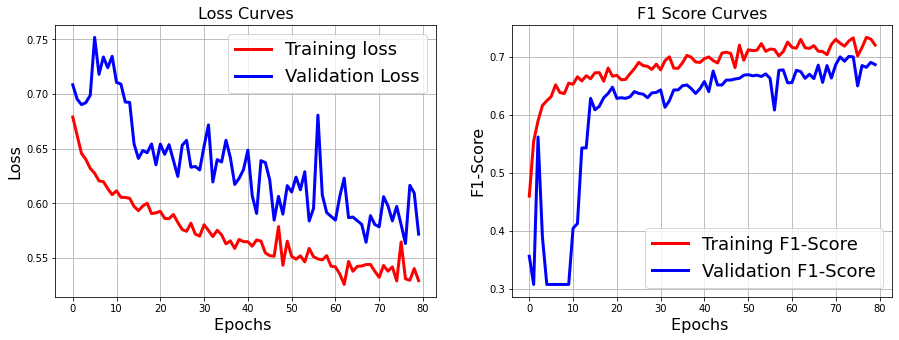

In [41]:
# represento la precisión y la pérdida del modelo
plot_training_curves(history)


In [42]:
# Image augmentation para mejorar el rendimiento del modelo realizando rotaciones, zoom, etc..
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

#escalado
validation_datagen = ImageDataGenerator(rescale=1./255)

#escalado
test_datagen = ImageDataGenerator(rescale=1./255)


# generador de imágenes de entrenamiento
train_generator = train_datagen.flow_from_directory(
    'data/practica_DL_UOC_2022/Fold0/train/',
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    color_mode = 'rgb',
    class_mode='categorical')

# generador de imágenes de validación
validation_generator = validation_datagen.flow_from_directory(
    'data/practica_DL_UOC_2022/Fold0/valid/',
    target_size=(224, 224),
    batch_size=32,
    shuffle = False,
    color_mode = 'rgb',
    class_mode='categorical')

# generador de imágenes de test
test_generator = test_datagen.flow_from_directory(
    'data/practica_DL_UOC_2022/Fold0/test/',
    target_size=(224, 224),
    batch_size=32,
    shuffle = False,
    color_mode = 'rgb',
    class_mode='categorical')

Found 1379 images belonging to 2 classes.
Found 154 images belonging to 2 classes.
Found 174 images belonging to 2 classes.


In [43]:
filenames = test_generator.filenames
nb_samples = len(filenames)

#Confusion Matrix and Classification Report
#Y_pred = modelo1.predict(test_generator, steps = nb_samples)
Y_pred = model_1.predict(test_generator, steps=nb_samples)
# como tengo la sigmoid, convieerto a 0 los elementos
#y_pred = [0 if x < 0.5 else 1 for x in Y_pred]
y_pred = np.argmax(Y_pred, axis=1)


print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(test_generator.classes,
      y_pred, target_names=target_names))

Confusion Matrix
[[64 28]
 [14 68]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.82      0.70      0.75        92
      normal       0.71      0.83      0.76        82

    accuracy                           0.76       174
   macro avg       0.76      0.76      0.76       174
weighted avg       0.77      0.76      0.76       174



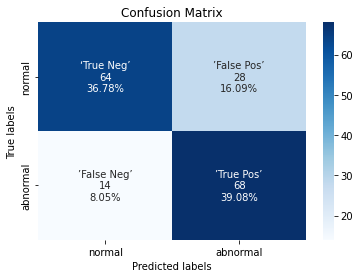

In [44]:
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
group_names = ['‘True Neg’','’False Pos’','’False Neg’','’True Pos’']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['normal', 'abnormal']); ax.yaxis.set_ticklabels(['normal', 'abnormal'])
plt.show()

In [45]:
# Model 1
# Modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*
def creador_modelo(n_classes, shape, optimizer, lr):
    prev_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=shape)
    model_1 = models.Sequential()
    # freeze layers
    for layer in model_1.layers:
        layer.trainable = False
    model_1.add(prev_model)
    # sustituir la capa de clasificación por una capa GlobalAveragePooling2D
    model_1.add(layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D'))
    # layer of "BatchNormalization"
    model_1.add(layers.BatchNormalization())
    # layer of "Dropout"
    model_1.add(layers.Dropout(0.2))
    # layer of Fully Connected
    model_1.layers[-1].trainable = True
    model_1.add(layers.Dense(n_classes, activation='sigmoid'))
    # compile the model
    if optimizer == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    #model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model_1.summary()


    # compile the model
    model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                            loss='binary_crossentropy',
                            metrics=tfa.metrics.F1Score(num_classes=n_classes, average='macro'),
                            run_eagerly=True)
    # freeze layers
    for layer in model_1.layers:
        layer.trainable = False
    # save the model
    #model_1.save('data/models/model_1.h5')

    # save weights
    #model_1.save_weights('data/models/model_1_weights.h5')

    return model_1


In [46]:

model_1_A = creador_modelo(2, (224, 224, 3), 'Adam', 0.001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 GlobalAveragePooling2D (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 batch_normalization_3 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 4,057,253
Trainable params: 4,012,670
Non-

In [47]:
train = X_train
batch_size = 32
valid = x_valid
steps_per_epoch = train // batch_size
validation_steps = valid // batch_size
epoch = 10
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1,
        mode='auto',
        min_delta=0.0001,
        cooldown=0,
        min_lr=0
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=5,
        verbose=1,
        mode='auto',
        baseline=None,
        restore_best_weights=True
    )
]


In [48]:
# train the model
history_1 = model_1_A.fit(x=X_train,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_valid,y_valid),
                        callbacks=callbacks,
                        verbose=1)
                        

Epoch 1/10
44/44 [==============================] - 18s 374ms/step - loss: 0.6173 - f1_score: 0.7220 - val_loss: 0.7243 - val_f1_score: 0.3502 - lr: 1.0000e-04
Epoch 2/10
44/44 [==============================] - 16s 366ms/step - loss: 0.3494 - f1_score: 0.8648 - val_loss: 0.7349 - val_f1_score: 0.3502 - lr: 1.0000e-04
Epoch 3/10
44/44 [==============================] - 16s 365ms/step - loss: 0.2705 - f1_score: 0.9036 - val_loss: 0.7261 - val_f1_score: 0.3502 - lr: 1.0000e-04
Epoch 4/10
44/44 [==============================] - 16s 370ms/step - loss: 0.2031 - f1_score: 0.9210 - val_loss: 0.6945 - val_f1_score: 0.3502 - lr: 1.0000e-04
Epoch 5/10
44/44 [==============================] - 17s 379ms/step - loss: 0.1768 - f1_score: 0.9392 - val_loss: 0.6939 - val_f1_score: 0.3502 - lr: 1.0000e-04
Epoch 6/10
44/44 [==============================] - 20s 453ms/step - loss: 0.1560 - f1_score: 0.9502 - val_loss: 0.7000 - val_f1_score: 0.3502 - lr: 1.0000e-04
Epoch 7/10
44/44 [======================

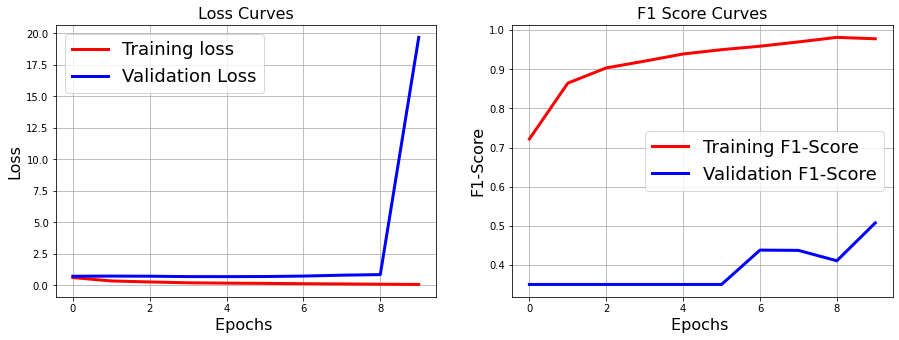

In [49]:
# represento la precisión y la pérdida del modelo
plot_training_curves(history_1)

In [50]:
filenames = test_generator.filenames
nb_samples = len(filenames)

#Confusion Matrix and Classification Report
#Y_pred = modelo1.predict(test_generator, steps = nb_samples)
Y_pred = model_1.predict(test_generator, steps=nb_samples)
# como tengo la sigmoid, convieerto a 0 los elementos
#y_pred = [0 if x < 0.5 else 1 for x in Y_pred]
y_pred = np.argmax(Y_pred, axis=1)


print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(test_generator.classes,
      y_pred, target_names=target_names))

Confusion Matrix
[[64 28]
 [14 68]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.82      0.70      0.75        92
      normal       0.71      0.83      0.76        82

    accuracy                           0.76       174
   macro avg       0.76      0.76      0.76       174
weighted avg       0.77      0.76      0.76       174



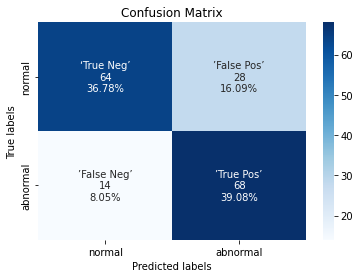

In [51]:
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
group_names = ['‘True Neg’','’False Pos’','’False Neg’','’True Pos’']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['normal', 'abnormal']); ax.yaxis.set_ticklabels(['normal', 'abnormal'])
plt.show()

### Modelo 2
modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*.
 A partir de los pesos encontrados para el modelo 1, se entrena descongelando las últimas 20 capas, pero dejando las capas de *BatchNorm* congeladas  

In [52]:
shape = (224, 224, 3)
num_classes = 2

In [53]:
head_model = tf.keras.applications.EfficientNetB0(input_shape=shape, include_top=False, weights='imagenet')
# Freeze all layers
head_model.trainable = False
inputs = tf.keras.layers.Input(shape=shape)
# añadimos capas
head_model = head_model(inputs, training=True)
# GlobalMaxPooling2D
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = tf.keras.layers.BatchNormalization()(head_model)
head_model = Dropout(0.2)(head_model)
outputs = Dense(num_classes, activation='softmax')(head_model)
model2 = tf.keras.Model(inputs, outputs)

# cargamos los pesos del modelo 1
model2.load_weights('data/models/model_1_weights.h5',
                    skip_mismatch=False, by_name=True)

# entrenamos las 20 últimas capas
for layer in model2.layers[:20]:
  layer.trainable = True

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
lr = 1e-3
epochs = 80
batch_size = 32
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=20,
        verbose=1,
        mode='auto',
        min_delta=0.0001,
        cooldown=0,
        min_lr=0
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=10,
        verbose=1,
        mode='auto',
        baseline=None,
        restore_best_weights=True
    )
]

# Compile
# model2.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

model2.compile(optimizer=optimizer, loss='categorical_crossentropy',
    metrics=tfa.metrics.F1Score(num_classes=num_classes, average='macro'))

model2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_4 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 2562

In [54]:
# freeze layers
for layer in model2.layers:
  layer.trainable = False

# save model2
model2.save('data/models/model_2.h5')
# save weights of model2
model2.save_weights('data/models/model_2_weights.h5')


In [55]:
batch_size = 32
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size


In [56]:

# Fit
H_model_2 = model2.fit(
    train_generator,
    steps_per_epoch= steps_per_epoch,
    epochs= 80,
    validation_data= validation_generator,
    validation_steps= validation_steps,
    callbacks=callbacks
)



Epoch 1/80
43/43 [==============================] - 30s 489ms/step - loss: 0.6909 - f1_score: 0.7509 - val_loss: 0.8117 - val_f1_score: 0.5690 - lr: 0.0010
Epoch 2/80
43/43 [==============================] - 20s 458ms/step - loss: 0.5836 - f1_score: 0.7854 - val_loss: 0.8256 - val_f1_score: 0.5626 - lr: 0.0010
Epoch 3/80
43/43 [==============================] - 20s 456ms/step - loss: 0.3603 - f1_score: 0.8516 - val_loss: 0.9866 - val_f1_score: 0.5744 - lr: 0.0010
Epoch 4/80
43/43 [==============================] - 20s 451ms/step - loss: 0.3814 - f1_score: 0.8472 - val_loss: 1.1793 - val_f1_score: 0.5781 - lr: 0.0010
Epoch 5/80
43/43 [==============================] - 20s 450ms/step - loss: 0.2563 - f1_score: 0.8891 - val_loss: 1.3318 - val_f1_score: 0.6250 - lr: 0.0010
Epoch 6/80
43/43 [==============================] - 20s 452ms/step - loss: 0.2210 - f1_score: 0.9109 - val_loss: 1.2214 - val_f1_score: 0.6403 - lr: 0.0010
Epoch 7/80
43/43 [==============================] - 20s 451ms/st

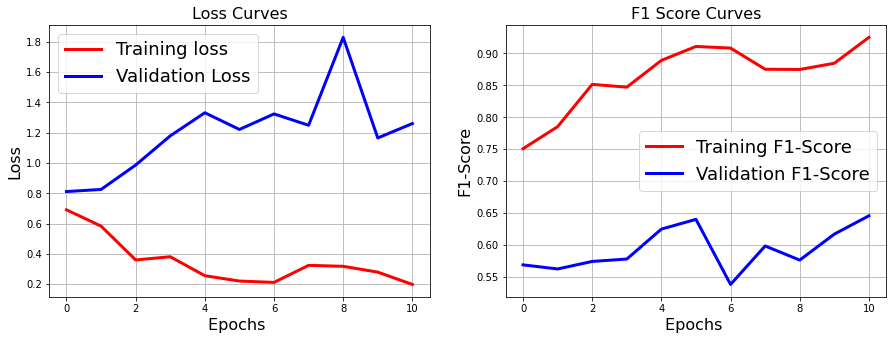

In [57]:
# represento la precisión y la pérdida del modelo
plot_training_curves(H_model_2)

In [58]:
filenames = test_generator.filenames
nb_samples = len(filenames)

#Confusion Matrix and Classification Report
#Y_pred = modelo1.predict(test_generator, steps = nb_samples)
Y_pred = model2.predict(test_generator, steps=nb_samples)
# como tengo la sigmoid, convieerto a 0 los elementos
#y_pred = [0 if x < 0.5 else 1 for x in Y_pred]
y_pred = np.argmax(Y_pred, axis=1)


print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(test_generator.classes,
      y_pred, target_names=target_names))

Confusion Matrix
[[91  1]
 [82  0]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.53      0.99      0.69        92
      normal       0.00      0.00      0.00        82

    accuracy                           0.52       174
   macro avg       0.26      0.49      0.34       174
weighted avg       0.28      0.52      0.36       174



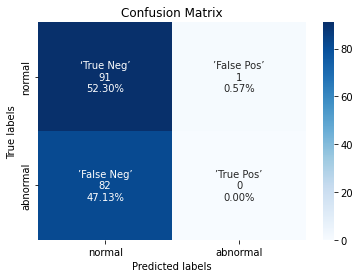

In [59]:
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
group_names = ['‘True Neg’','’False Pos’','’False Neg’','’True Pos’']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['normal', 'abnormal']); ax.yaxis.set_ticklabels(['normal', 'abnormal'])
plt.show()

### Modelo 3
Modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*.
A partir de los pesos del modelo 2, se descongelan todas las capas y se entrena la red en su totalidad 

In [60]:
head_model = tf.keras.applications.EfficientNetB0(
    input_shape=shape, include_top=False, weights='imagenet')
# Freeze all layers
head_model.trainable = False
inputs = tf.keras.layers.Input(shape=shape)
# añadimos capas
head_model = head_model(inputs, training=True)
# GlobalMaxPooling2D
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = tf.keras.layers.BatchNormalization()(head_model)
head_model = Dropout(0.2)(head_model)
outputs = Dense(num_classes, activation='softmax')(head_model)
model3 = tf.keras.Model(inputs, outputs)

# save model3
model3.save('data/models/model_3.h5')
# save the weights
model3.save_weights('data/models/model_3_weights.h5')

# cargamos los pesos del modelo 2
model3.load_weights('data/models/model_2_weights.h5', skip_mismatch=False, by_name=True)
# descongelamos todas las capas
model3.trainable = True

# Compile
model3.compile(optimizer=optimizer, loss='categorical_crossentropy',
    metrics=tfa.metrics.F1Score(num_classes=num_classes, average='macro'))

model3.summary()

h_model_3 = model3.fit(
    train_generator,
    steps_per_epoch= steps_per_epoch,
    epochs= 80,
    validation_data= validation_generator,
    validation_steps= validation_steps,
    callbacks=callbacks
)


Epoch 1/80
43/43 [==============================] - 30s 520ms/step - loss: 1.0140 - f1_score: 0.6730 - val_loss: 1.0021 - val_f1_score: 0.5340 - lr: 0.0010
Epoch 2/80
43/43 [==============================] - 20s 454ms/step - loss: 0.5462 - f1_score: 0.7537 - val_loss: 0.9367 - val_f1_score: 0.3876 - lr: 0.0010
Epoch 3/80
43/43 [==============================] - 20s 452ms/step - loss: 0.4556 - f1_score: 0.7928 - val_loss: 1.2345 - val_f1_score: 0.5039 - lr: 0.0010
Epoch 4/80
43/43 [==============================] - 20s 454ms/step - loss: 0.4714 - f1_score: 0.8138 - val_loss: 0.7971 - val_f1_score: 0.4800 - lr: 0.0010
Epoch 5/80
43/43 [==============================] - 20s 452ms/step - loss: 0.6274 - f1_score: 0.7741 - val_loss: 1.2145 - val_f1_score: 0.3976 - lr: 0.0010
Epoch 6/80
43/43 [==============================] - 20s 453ms/step - loss: 0.5579 - f1_score: 0.7854 - val_loss: 0.7621 - val_f1_score: 0.5045 - lr: 0.0010
Epoch 7/80
43/43 [==============================] - 20s 452ms/st

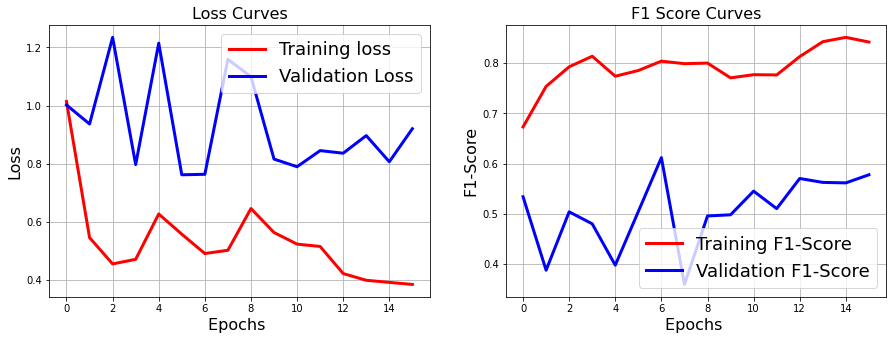

In [61]:
# represento la precisión y la pérdida del modelo
plot_training_curves(h_model_3)

In [62]:
filenames = test_generator.filenames
nb_samples = len(filenames)

#Confusion Matrix and Classification Report
#Y_pred = modelo1.predict(test_generator, steps = nb_samples)
Y_pred = model3.predict(test_generator, steps=nb_samples)
# como tengo la sigmoid, convieerto a 0 los elementos
#y_pred = [0 if x < 0.5 else 1 for x in Y_pred]
y_pred = np.argmax(Y_pred, axis=1)


print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(test_generator.classes,
      y_pred, target_names=target_names))

Confusion Matrix
[[31 61]
 [24 58]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.56      0.34      0.42        92
      normal       0.49      0.71      0.58        82

    accuracy                           0.51       174
   macro avg       0.53      0.52      0.50       174
weighted avg       0.53      0.51      0.49       174



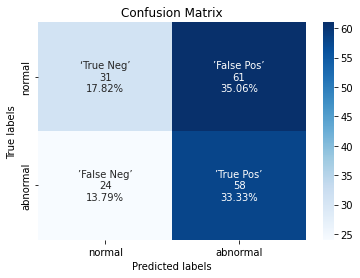

In [63]:
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
group_names = ['‘True Neg’','’False Pos’','’False Neg’','’True Pos’']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['normal', 'abnormal']); ax.yaxis.set_ticklabels(['normal', 'abnormal'])
plt.show()

### Modelo 4

Una capa convulucional

In [64]:
# CNN model of one convolutional layer
def build_model_4(num_classes, input_shape):
    # input
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # convolutional layer
    x = tf.keras.layers.Conv2D(
        32, (3, 3), activation='relu', padding='same', name='conv1')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool1')(x)
    x = tf.keras.layers.Dropout(0.2, name='dropout1')(x)
    
    # flatten
    x = tf.keras.layers.Flatten()(x)
    
    # dense layer
    x = tf.keras.layers.Dense(128, activation='relu', name='dense1')(x)
    x = tf.keras.layers.Dropout(0.2, name='dropout2')(x)
    
    # output layer
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='pred')(x)
    
    # compile
    model = tf.keras.Model(inputs, outputs, name="CNN")
    
    # get the model summary
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
        metrics=tfa.metrics.F1Score(num_classes=num_classes, average='macro'))

    # save the model
    model.save('data/models/model_4.h5')
    # save the weights
    model.save_weights('data/models/model_4_weights.h5')

    return model

model_4 = build_model_4(num_classes, shape)

model_4.summary()

# Fit
H_model_4 = model_4.fit(
    train_generator,
    steps_per_epoch= steps_per_epoch,
    epochs= 80,
    validation_data= validation_generator,
    validation_steps= validation_steps,
    callbacks=callbacks
)


Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 32)      0         
                                                                 
 dropout1 (Dropout)          (None, 112, 112, 32)      0         
                                                                 
 flatten (Flatten)           (None, 401408)            0         
                                                               

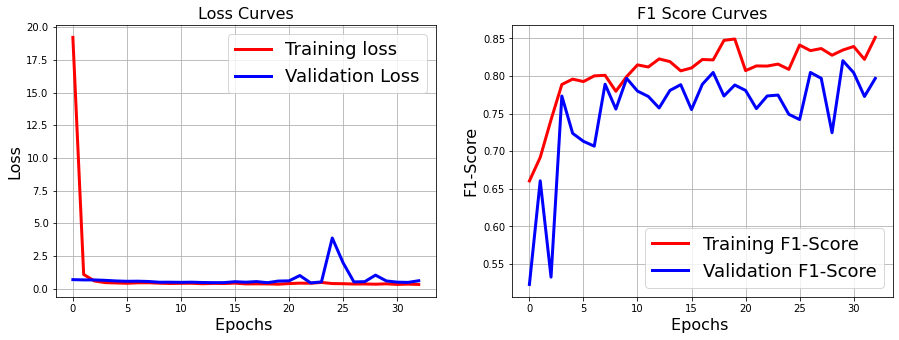

In [65]:
# represento la precisión y la pérdida del modelo
plot_training_curves(H_model_4)

In [66]:
filenames = test_generator.filenames
nb_samples = len(filenames)

#Confusion Matrix and Classification Report
#Y_pred = modelo1.predict(test_generator, steps = nb_samples)
Y_pred = model_4.predict(test_generator, steps=nb_samples)
# como tengo la sigmoid, convieerto a 0 los elementos
#y_pred = [0 if x < 0.5 else 1 for x in Y_pred]
y_pred = np.argmax(Y_pred, axis=1)


print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(test_generator.classes,
      y_pred, target_names=target_names))

Confusion Matrix
[[73 19]
 [ 7 75]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.91      0.79      0.85        92
      normal       0.80      0.91      0.85        82

    accuracy                           0.85       174
   macro avg       0.86      0.85      0.85       174
weighted avg       0.86      0.85      0.85       174



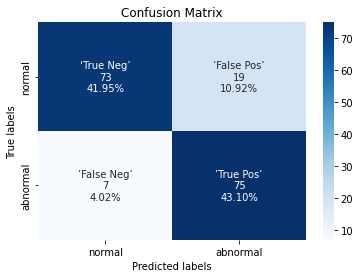

In [67]:
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
group_names = ['‘True Neg’','’False Pos’','’False Neg’','’True Pos’']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['normal', 'abnormal']); ax.yaxis.set_ticklabels(['normal', 'abnormal']);
plt.show()

### Modelo 5

Un modelo sencillo

In [68]:
# get a simply model
def build_model_5(num_classes, input_shape):
    # input
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # flatten
    x = tf.keras.layers.Flatten()(inputs)
    
    # dense layer
    x = tf.keras.layers.Dense(128, activation='relu', name='dense1')(x)
    x = tf.keras.layers.Dropout(0.2, name='dropout2')(x)
    
    # output layer
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='pred')(x)
    
    # compile
    model = tf.keras.Model(inputs, outputs, name="CNN")
    
    # get the model summary
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
    metrics=tfa.metrics.F1Score(num_classes=num_classes, average='macro'))
    # get the model summary
    model.summary()

    # save the model
    model.save('data/models/model_5.h5')
    # save the weights
    model.save_weights('data/models/model_5_weights.h5')

    return model

model_5 = build_model_5(num_classes, shape)

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense1 (Dense)              (None, 128)               19267712  
                                                                 
 dropout2 (Dropout)          (None, 128)               0         
                                                                 
 pred (Dense)                (None, 2)                 258       
                                                                 
Total params: 19,267,970
Trainable params: 19,267,970
Non-trainable params: 0
_________________________________________________________________


In [69]:
# Fit
H_model_5 = model_5.fit(
    train_generator,
    steps_per_epoch= steps_per_epoch,
    epochs= 80,
    validation_data= validation_generator,
    validation_steps= validation_steps,
    callbacks=callbacks
)

Epoch 1/80
43/43 [==============================] - 15s 351ms/step - loss: 8.0614 - f1_score: 0.5658 - val_loss: 2.4336 - val_f1_score: 0.3537 - lr: 0.0010
Epoch 2/80
43/43 [==============================] - 14s 329ms/step - loss: 0.7100 - f1_score: 0.5847 - val_loss: 0.6582 - val_f1_score: 0.4631 - lr: 0.0010
Epoch 3/80
43/43 [==============================] - 14s 333ms/step - loss: 0.7118 - f1_score: 0.6276 - val_loss: 0.6471 - val_f1_score: 0.6328 - lr: 0.0010
Epoch 4/80
43/43 [==============================] - 14s 328ms/step - loss: 0.6460 - f1_score: 0.6587 - val_loss: 0.6489 - val_f1_score: 0.6316 - lr: 0.0010
Epoch 5/80
43/43 [==============================] - 14s 332ms/step - loss: 0.9117 - f1_score: 0.6212 - val_loss: 0.6206 - val_f1_score: 0.6482 - lr: 0.0010
Epoch 6/80
43/43 [==============================] - 14s 329ms/step - loss: 0.6236 - f1_score: 0.6650 - val_loss: 0.6089 - val_f1_score: 0.6559 - lr: 0.0010
Epoch 7/80
43/43 [==============================] - 14s 326ms/st

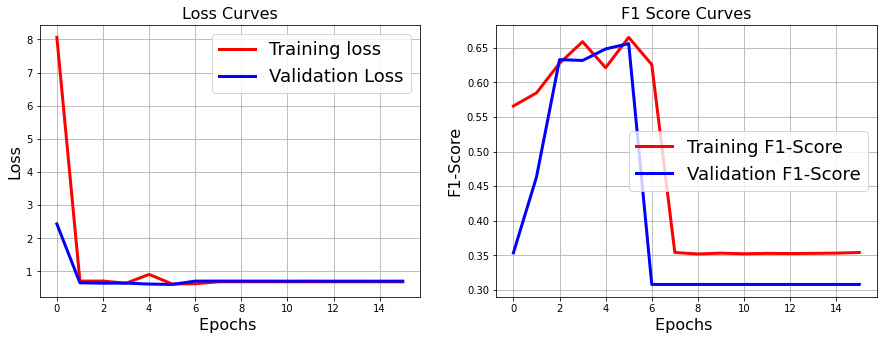

In [70]:
# represento la precisión y la pérdida del modelo
plot_training_curves(H_model_5)

In [71]:
filenames = test_generator.filenames
nb_samples = len(filenames)

#Confusion Matrix and Classification Report
#Y_pred = modelo1.predict(test_generator, steps = nb_samples)
Y_pred = model_5.predict(test_generator, steps=nb_samples)
# como tengo la sigmoid, convieerto a 0 los elementos
#y_pred = [0 if x < 0.5 else 1 for x in Y_pred]
y_pred = np.argmax(Y_pred, axis=1)


print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(test_generator.classes,
      y_pred, target_names=target_names))

Confusion Matrix
[[59 33]
 [12 70]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.83      0.64      0.72        92
      normal       0.68      0.85      0.76        82

    accuracy                           0.74       174
   macro avg       0.76      0.75      0.74       174
weighted avg       0.76      0.74      0.74       174



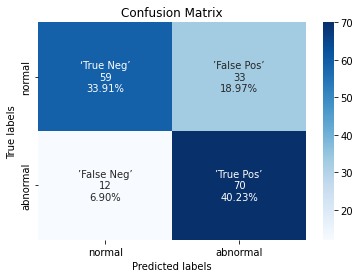

In [72]:
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
group_names = ['‘True Neg’','’False Pos’','’False Neg’','’True Pos’']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['normal', 'abnormal']); ax.yaxis.set_ticklabels(['normal', 'abnormal']);
plt.show()


# **Sección 3. Validación cruzada y discusión (3 puntos)**

El objetivo de la técnica de *cross validation* es seleccionar qué modelo es más adecuado, intentando reducir los sesgos y variaciones estadísticas en función de cómo se ha realizado la partición. En los apartados anteriores se ha trabajado con una de las particiones (**fold0**) y se han estudiado 5 modelos distintos.

En este caso, se debe:

- Aplicar una técnica de *cross validation* sobre el mejor de los modelos definidos anteriormente. Los datos ya contienen 10 particiones distintas (de **fold0** a **fold9**), por lo que se debe entrenar el modelo escogido sobre los datos de *train* de cada una de las particiones, evaluarlas, eligiendo en cada caso el mejor modelo de validación.
- Obtener el valor de **F1 score** de cada partición sobre el conjunto de test. De esta forma, se obtendrán 10 valores **F1 score** de test distintos.
- Calcular el valor medio y la desviación estándar.




Fold0
Epoch 1/80
44/44 [==============================] - 16s 368ms/step - loss: 0.5331 - f1_score: 0.7159 - val_loss: 0.5567 - val_f1_score: 0.7000
Epoch 2/80
44/44 [==============================] - 16s 358ms/step - loss: 0.5296 - f1_score: 0.7338 - val_loss: 0.5524 - val_f1_score: 0.7030
Epoch 3/80
44/44 [==============================] - 16s 359ms/step - loss: 0.5194 - f1_score: 0.7467 - val_loss: 0.5544 - val_f1_score: 0.7011
Epoch 4/80
44/44 [==============================] - 16s 356ms/step - loss: 0.5224 - f1_score: 0.7389 - val_loss: 0.5668 - val_f1_score: 0.6978
Epoch 5/80
44/44 [==============================] - 16s 360ms/step - loss: 0.5507 - f1_score: 0.7227 - val_loss: 0.5607 - val_f1_score: 0.7073
Epoch 6/80
44/44 [==============================] - 16s 361ms/step - loss: 0.5471 - f1_score: 0.7123 - val_loss: 0.5700 - val_f1_score: 0.7016
Epoch 7/80
44/44 [==============================] - 16s 356ms/step - loss: 0.5281 - f1_score: 0.7371 - val_loss: 0.5539 - val_f1_score: 

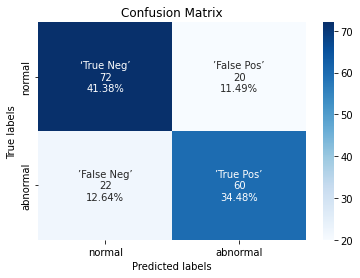

Fold1
Epoch 1/80
44/44 [==============================] - 16s 361ms/step - loss: 0.5302 - f1_score: 0.7355 - val_loss: 0.5539 - val_f1_score: 0.7073
Epoch 2/80
44/44 [==============================] - 16s 359ms/step - loss: 0.5265 - f1_score: 0.7448 - val_loss: 0.5492 - val_f1_score: 0.7155
Epoch 3/80
44/44 [==============================] - 16s 358ms/step - loss: 0.5232 - f1_score: 0.7377 - val_loss: 0.5503 - val_f1_score: 0.7094
Epoch 4/80
44/44 [==============================] - 16s 355ms/step - loss: 0.5225 - f1_score: 0.7350 - val_loss: 0.5644 - val_f1_score: 0.6899
Epoch 5/80
44/44 [==============================] - 16s 359ms/step - loss: 0.5259 - f1_score: 0.7354 - val_loss: 0.5532 - val_f1_score: 0.6938
Epoch 6/80
44/44 [==============================] - 16s 358ms/step - loss: 0.5302 - f1_score: 0.7264 - val_loss: 0.5563 - val_f1_score: 0.7133
Epoch 7/80
44/44 [==============================] - 16s 357ms/step - loss: 0.5264 - f1_score: 0.7346 - val_loss: 0.5498 - val_f1_score: 

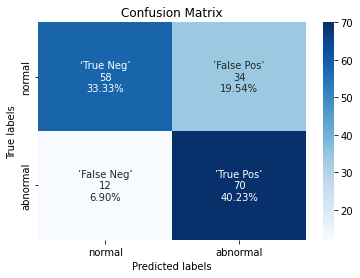

Fold2
Epoch 1/80
44/44 [==============================] - 16s 357ms/step - loss: 0.5275 - f1_score: 0.7381 - val_loss: 0.5518 - val_f1_score: 0.7005
Epoch 2/80
44/44 [==============================] - 16s 357ms/step - loss: 0.5257 - f1_score: 0.7329 - val_loss: 0.5462 - val_f1_score: 0.7083
Epoch 3/80
44/44 [==============================] - 16s 357ms/step - loss: 0.5272 - f1_score: 0.7336 - val_loss: 0.5468 - val_f1_score: 0.7181
Epoch 4/80
44/44 [==============================] - 16s 357ms/step - loss: 0.5106 - f1_score: 0.7488 - val_loss: 0.5463 - val_f1_score: 0.7103
Epoch 5/80
44/44 [==============================] - 16s 360ms/step - loss: 0.5313 - f1_score: 0.7236 - val_loss: 0.5513 - val_f1_score: 0.7005
Epoch 6/80
44/44 [==============================] - 16s 360ms/step - loss: 0.5224 - f1_score: 0.7442 - val_loss: 0.5544 - val_f1_score: 0.7133
Epoch 7/80
44/44 [==============================] - 16s 357ms/step - loss: 0.5138 - f1_score: 0.7413 - val_loss: 0.5510 - val_f1_score: 

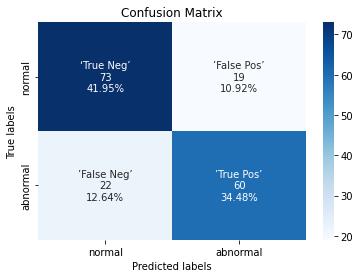

Fold3
Epoch 1/80
44/44 [==============================] - 16s 360ms/step - loss: 0.5231 - f1_score: 0.7345 - val_loss: 0.5435 - val_f1_score: 0.7083
Epoch 2/80
44/44 [==============================] - 16s 358ms/step - loss: 0.5216 - f1_score: 0.7446 - val_loss: 0.5429 - val_f1_score: 0.7240
Epoch 3/80
44/44 [==============================] - 16s 358ms/step - loss: 0.5216 - f1_score: 0.7449 - val_loss: 0.5426 - val_f1_score: 0.7119
Epoch 4/80
44/44 [==============================] - 16s 361ms/step - loss: 0.5163 - f1_score: 0.7389 - val_loss: 0.5468 - val_f1_score: 0.7133
Epoch 5/80
44/44 [==============================] - 16s 357ms/step - loss: 0.5312 - f1_score: 0.7151 - val_loss: 0.5435 - val_f1_score: 0.7188
Epoch 6/80
44/44 [==============================] - 16s 359ms/step - loss: 0.5149 - f1_score: 0.7387 - val_loss: 0.5536 - val_f1_score: 0.7037
Epoch 7/80
44/44 [==============================] - 16s 359ms/step - loss: 0.5256 - f1_score: 0.7328 - val_loss: 0.5405 - val_f1_score: 

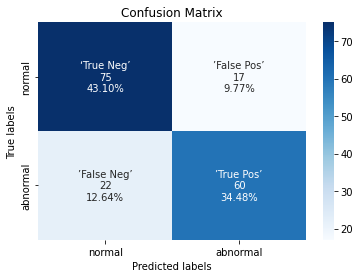

Fold4
Epoch 1/80
44/44 [==============================] - 16s 361ms/step - loss: 0.5179 - f1_score: 0.7321 - val_loss: 0.5458 - val_f1_score: 0.7115
Epoch 2/80
44/44 [==============================] - 16s 357ms/step - loss: 0.5150 - f1_score: 0.7370 - val_loss: 0.5371 - val_f1_score: 0.7240
Epoch 3/80
44/44 [==============================] - 16s 356ms/step - loss: 0.5089 - f1_score: 0.7337 - val_loss: 0.5613 - val_f1_score: 0.6831
Epoch 4/80
44/44 [==============================] - 16s 356ms/step - loss: 0.5312 - f1_score: 0.7181 - val_loss: 0.5695 - val_f1_score: 0.6665
Epoch 5/80
44/44 [==============================] - 16s 357ms/step - loss: 0.5319 - f1_score: 0.7268 - val_loss: 0.5483 - val_f1_score: 0.6958
Epoch 6/80
44/44 [==============================] - 16s 358ms/step - loss: 0.5103 - f1_score: 0.7409 - val_loss: 0.5321 - val_f1_score: 0.7399
Epoch 7/80
44/44 [==============================] - 16s 354ms/step - loss: 0.5212 - f1_score: 0.7404 - val_loss: 0.5372 - val_f1_score: 

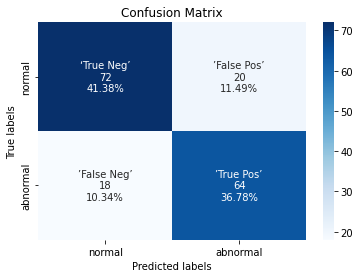

Fold5
Epoch 1/80
44/44 [==============================] - 16s 364ms/step - loss: 0.5150 - f1_score: 0.7363 - val_loss: 0.5307 - val_f1_score: 0.7399
Epoch 2/80
44/44 [==============================] - 16s 362ms/step - loss: 0.5075 - f1_score: 0.7405 - val_loss: 0.5312 - val_f1_score: 0.7277
Epoch 3/80
44/44 [==============================] - 16s 362ms/step - loss: 0.5112 - f1_score: 0.7416 - val_loss: 0.5291 - val_f1_score: 0.7338
Epoch 4/80
44/44 [==============================] - 16s 359ms/step - loss: 0.5021 - f1_score: 0.7446 - val_loss: 0.5336 - val_f1_score: 0.7314
Epoch 5/80
44/44 [==============================] - 16s 360ms/step - loss: 0.5086 - f1_score: 0.7459 - val_loss: 0.5299 - val_f1_score: 0.7367
Epoch 6/80
44/44 [==============================] - 16s 361ms/step - loss: 0.5254 - f1_score: 0.7217 - val_loss: 0.5416 - val_f1_score: 0.7077
Epoch 7/80
44/44 [==============================] - 16s 358ms/step - loss: 0.5089 - f1_score: 0.7381 - val_loss: 0.5461 - val_f1_score: 

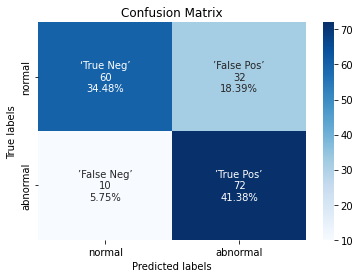

Fold6
Epoch 1/80
44/44 [==============================] - 16s 362ms/step - loss: 0.5055 - f1_score: 0.7406 - val_loss: 0.5301 - val_f1_score: 0.7435
Epoch 2/80
44/44 [==============================] - 16s 361ms/step - loss: 0.5025 - f1_score: 0.7442 - val_loss: 0.5267 - val_f1_score: 0.7348
Epoch 3/80
44/44 [==============================] - 16s 362ms/step - loss: 0.5106 - f1_score: 0.7352 - val_loss: 0.5350 - val_f1_score: 0.7210
Epoch 4/80
44/44 [==============================] - 16s 359ms/step - loss: 0.5052 - f1_score: 0.7558 - val_loss: 0.5327 - val_f1_score: 0.7285
Epoch 5/80
44/44 [==============================] - 16s 361ms/step - loss: 0.5277 - f1_score: 0.7285 - val_loss: 0.5270 - val_f1_score: 0.7305
Epoch 6/80
44/44 [==============================] - 16s 359ms/step - loss: 0.5046 - f1_score: 0.7603 - val_loss: 0.5401 - val_f1_score: 0.7208
Epoch 7/80
44/44 [==============================] - 16s 362ms/step - loss: 0.5084 - f1_score: 0.7387 - val_loss: 0.5444 - val_f1_score: 

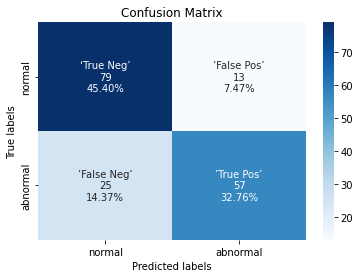

Fold7
Epoch 1/80
44/44 [==============================] - 16s 362ms/step - loss: 0.5101 - f1_score: 0.7500 - val_loss: 0.5303 - val_f1_score: 0.7361
Epoch 2/80
44/44 [==============================] - 16s 361ms/step - loss: 0.4999 - f1_score: 0.7425 - val_loss: 0.5333 - val_f1_score: 0.7210
Epoch 3/80
44/44 [==============================] - 16s 362ms/step - loss: 0.5092 - f1_score: 0.7388 - val_loss: 0.5450 - val_f1_score: 0.7075
Epoch 4/80
44/44 [==============================] - 16s 370ms/step - loss: 0.5161 - f1_score: 0.7269 - val_loss: 0.5251 - val_f1_score: 0.7443
Epoch 5/80
44/44 [==============================] - 16s 365ms/step - loss: 0.5019 - f1_score: 0.7495 - val_loss: 0.5292 - val_f1_score: 0.7329
Epoch 6/80
44/44 [==============================] - 16s 363ms/step - loss: 0.4953 - f1_score: 0.7554 - val_loss: 0.5356 - val_f1_score: 0.7210
Epoch 7/80
44/44 [==============================] - 16s 362ms/step - loss: 0.5073 - f1_score: 0.7431 - val_loss: 0.5311 - val_f1_score: 

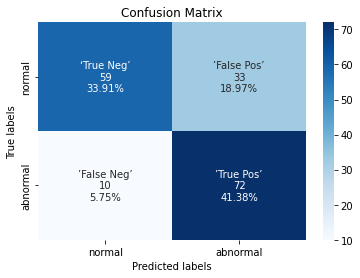

Fold8
Epoch 1/80
44/44 [==============================] - 16s 362ms/step - loss: 0.5042 - f1_score: 0.7413 - val_loss: 0.5278 - val_f1_score: 0.7460
Epoch 2/80
44/44 [==============================] - 16s 362ms/step - loss: 0.5099 - f1_score: 0.7405 - val_loss: 0.5316 - val_f1_score: 0.7332
Epoch 3/80
44/44 [==============================] - 16s 358ms/step - loss: 0.5185 - f1_score: 0.7371 - val_loss: 0.5322 - val_f1_score: 0.7285
Epoch 4/80
44/44 [==============================] - 16s 359ms/step - loss: 0.4915 - f1_score: 0.7573 - val_loss: 0.5262 - val_f1_score: 0.7367
Epoch 5/80
44/44 [==============================] - 16s 358ms/step - loss: 0.5095 - f1_score: 0.7408 - val_loss: 0.5412 - val_f1_score: 0.7077
Epoch 6/80
44/44 [==============================] - 16s 362ms/step - loss: 0.4965 - f1_score: 0.7500 - val_loss: 0.5282 - val_f1_score: 0.7326
Epoch 7/80
44/44 [==============================] - 16s 360ms/step - loss: 0.4911 - f1_score: 0.7581 - val_loss: 0.5332 - val_f1_score: 

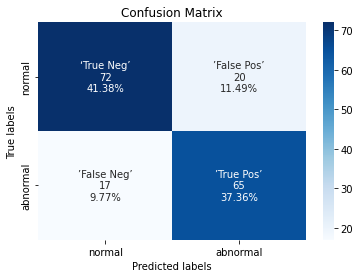

Fold9
Epoch 1/80
44/44 [==============================] - 16s 363ms/step - loss: 0.5033 - f1_score: 0.7409 - val_loss: 0.5302 - val_f1_score: 0.7326
Epoch 2/80
44/44 [==============================] - 16s 361ms/step - loss: 0.5007 - f1_score: 0.7530 - val_loss: 0.5261 - val_f1_score: 0.7358
Epoch 3/80
44/44 [==============================] - 16s 358ms/step - loss: 0.4835 - f1_score: 0.7638 - val_loss: 0.5333 - val_f1_score: 0.7210
Epoch 4/80
44/44 [==============================] - 16s 367ms/step - loss: 0.4867 - f1_score: 0.7585 - val_loss: 0.5313 - val_f1_score: 0.7285
Epoch 5/80
44/44 [==============================] - 16s 356ms/step - loss: 0.4998 - f1_score: 0.7543 - val_loss: 0.5275 - val_f1_score: 0.7367
Epoch 6/80
44/44 [==============================] - 16s 359ms/step - loss: 0.5031 - f1_score: 0.7382 - val_loss: 0.5469 - val_f1_score: 0.6995
Epoch 7/80
44/44 [==============================] - 16s 360ms/step - loss: 0.5061 - f1_score: 0.7392 - val_loss: 0.5319 - val_f1_score: 

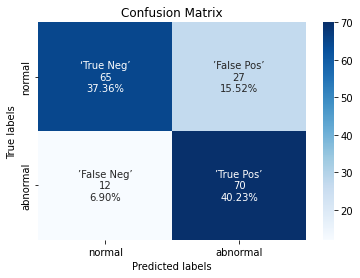

In [73]:
f1_sco = []

for i in range(10):
  fold = 'Fold'+str(i)

  print(fold)

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)
  history_callback = model_1.fit(train_generator, validation_data= validation_generator, epochs=80, verbose=1, batch_size = 32, callbacks = [es])

  filenames = test_generator.filenames
  nb_samples = len(filenames)

  # confusión matrix
  Y_pred = model_1.predict(test_generator, steps = nb_samples)
  y_pred = np.argmax(Y_pred, axis=1)

  target_names = list(train_generator.class_indices.keys())
  print(classification_report(test_generator.classes, y_pred, target_names=target_names))
  res = classification_report(test_generator.classes, y_pred, target_names=target_names, output_dict = True)

  f1_sco.append(res['normal']['f1-score'])
  f1_sco.append(res['abnormal']['f1-score'])

  cf_matrix = confusion_matrix(test_generator.classes, y_pred)
  group_names = ['‘True Neg’','’False Pos’','’False Neg’','’True Pos’']
  group_counts = ['{0:0.0f}'.format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  ax= plt.subplot()
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax=ax)

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['normal', 'abnormal']); ax.yaxis.set_ticklabels(['normal', 'abnormal']);
  plt.show()

  



In [74]:
print(f1_sco)

[0.7407407407407408, 0.7741935483870968, 0.7526881720430108, 0.7160493827160495, 0.7453416149068323, 0.7807486631016043, 0.7547169811320754, 0.7936507936507937, 0.7710843373493976, 0.7912087912087912, 0.7741935483870966, 0.7407407407407407, 0.75, 0.8061224489795917, 0.7700534759358288, 0.7329192546583851, 0.7784431137724551, 0.7955801104972375, 0.782122905027933, 0.7692307692307693]


In [75]:
import numpy as np
print(f'La media del F1-Score de todos los conjuntos es: {np.mean(f1_sco)}')

La media del F1-Score de todos los conjuntos es: 0.7659914696233215


In [76]:
print(f'La desviación estándard de los conjuntos es: {np.std(f1_sco)}')

La desviación estándard de los conjuntos es: 0.022974847148962918



Finalmente, fíjate en las matrices de *cross validation* que se han obtenido en la sección 2. El Glaucoma es una patología muy grave, por lo que es importante reducir los **falsos negativos (FN)** del modelo. ¿Qué estrategia seguirías para conseguir este propósito y qué penalizaciones podría tener esta decisión?

Para incrementar el rendimiento de nuestro modelo y por tanto reducir el número de falsos negativos podíamos tener en cuenta las siguientes opciones.


*   En nuestro caso tenemos unas 17 mil imágenes, para obtener mejores resultados podíamos aumentar el número de imágenes del conjunto de entrenamiento
*   Reducir aún más el learning rate y probar con parámetros más pequeños

Como penalizaciones, podemos hablar del incremento temporal y computacional al incrementar tanto el learning rate como el número de imágenes a procesar.





# **Sección 4. Análisis crítico (1,5 puntos)**

Contesta, de forma razonada y justificada, a las siguientes preguntas:

  a) Para la realización de la práctica se han entregado las *folds* preparadas para el entrenamiento.

  i) Indicar qué estrategia de diseño hubieras seguido si las hubieras tenido que definir tú.

  ii) Indicar qué puntos son importantes en el diseño de estas particiones para que los modelos resultantes tengan una buena capacidad de generalización.

  b) Realizar un análisis crítico de los resultados obtenidos y las conclusiones a las que has llegado después de realizar esta práctica.



1.   La estrategia de diseño me parece la adecuada, 
cargar la totalidad de imágenes en memoria requeriría grandes recursos y tener las imágenes separadas en folds parece la óptima. A su vez, el uso de la función flow_from_directory carga un tren de imágenes para evitar colapsar la memoria. Como hemos visto durante el ejercicio, la distribución de imágenes en los distintos folds es casi la misma, tenemos una cantidad igual o similar de imágenes en cada fold de validación, test y entrenamiento.
2.   Como conclusiones podemos decir:

  *   El uso de modelos preentrenados como efficientnet nos ayuda a obtener buenos resultados evitándonos realizar gran parte del entrenamiento.
  *   La aplicación de transfer learning también ha contribuido con éxito a la mejora del modelo
La aplicación de transfer learning también ha contribuido con éxito a la mejora del modelo
  *   La búsqueda del mejor modelo y de los mejores hiperparámetros requiere de grandes tiempos de ejecución y una gran cantidad pruebas.
  *   La clave en este tipo de estudios, además de obtener un valor máximo de precisión de los resultados es reducir al máximo los falsos negativos, ya que estaríamos diagnosticando de forma incorrecta a un paciente con un problema.












8. Entrega

El entregable será un archivo comprimido en formato ZIP con los siguientes documentos:

- **Informe en formato PDF** de entre 8 y 10 páginas de longitud, aproximadamente. No debe contener código (salvo mencionar alguna librería que sea importante indicar, o similar)
- **Código fuente** completo de la práctica. El código usado para todas las etapas de la práctica debe estar correctamente comentado para facilitar su comprensión. Podéis utilizar archivos Python nativos (.py) o basados en Jupyter Notebook (en este caso se debe entregar la versión .ipynb, y la exportación en formato HTML).

Para el **informe** se puede usar la siguiente guía:

- Tamaño de letra 11 o 12
- Fuente: Arial o similar
- Interlineado sencillo
- Las capturas de pantalla (por ejemplo, las gráficas de rendimiento) o los fragmentos de código (si se consideran relevantes) deben estar pensados para ilustrar y no para ser protagonistas.
- Se valora el informe como conjunto y no una sucesión de resultados.
